<a href="https://colab.research.google.com/github/jp-prud/PDI/blob/main/Atividade_3_Filtragem_Espacial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Suavização

Convolução

In [ ]:
def convolucao(image, kernel):;
    kHeight, kWidth = kernel.shape

    padHeight = kHeight // 2
    padWidth = kWidth // 2

    result = np.zeros((height, width), dtype=np.float32)

    for i in range(padHeight, height - padHeight):
        for j in range(padWidth, width - padWidth):
            conv = 0.0

            for m in range(-padHeight, padHeight + 1):
                for n in range(-padWidth, padWidth + 1):
                    conv += image[i + m, j + n] * kernel[m + padHeight, n + padWidth]
            result[i, j] = conv
    return result

Filtro gaussiano

In [ ]:
import cv2
import numpy as np
import scipy.stats as stats
from skimage.util import random_noise

image = cv2.imread('t1.jpg')

def filtro_gaussiano_manual(image, tamanho_mascara, desvio_padrao):
    altura, largura, _ = image.shape
    mascara = np.zeros((tamanho_mascara, tamanho_mascara))
    centro = tamanho_mascara // 2

    for y in range(tamanho_mascara):
        for x in range(tamanho_mascara):
            ky = y - centro
            kx = x - centro
            mascara[y, x] = stats.norm.pdf(np.sqrt(ky ** 2 + kx ** 2), scale=desvio_padrao)
    mascara /= mascara.sum()

    output = np.zeros_like(image)

    for y in range(altura):
        for x in range(largura):
            for c in range(3):
                soma = 0
                for ky in range(tamanho_mascara):
                    for kx in range(tamanho_mascara):
                        py = y - tamanho_mascara // 2 + ky
                        px = x - tamanho_mascara // 2 + kx
                        if py >= 0 and px >= 0 and py < altura and px < largura:
                            soma += image[py, px, c] * mascara[ky, kx]
                output[y, x, c] = int(soma)

    return output

img_ruido = random_noise(image, mode='s&p', amount=0.05)
img_ruido = (255 * img_ruido).astype(np.uint8)

smoothed_3x3_manual = filtro_gaussiano_manual(img_ruido, 3, 1)
smoothed_5x5_manual = filtro_gaussiano_manual(img_ruido, 5, 1)
smoothed_7x7_manual = filtro_gaussiano_manual(img_ruido, 7, 1)

cv2.imshow('Gaussiana Manual 3x3', smoothed_3x3_manual)
cv2.imshow('Gaussiana Manual 5x5', smoothed_5x5_manual)
cv2.imshow('Gaussiana Manual 7x7', smoothed_7x7_manual)
cv2.waitKey(0)
cv2.destroyAllWindows()

Cria-se uma matrizde zeros para representar a máscara gaussiana, tendo o seu valor determinado pelo parametro da função. Após isto, o centro da máscara é calculado, o que auxilia a definir o ponto de referência para aplicar a mascara em cada pixel.
O código entra em loop para aplicar a mascara, percorrendo cada coordenada da imagem, no interior do loop, o calcula-se o valor da distribuição da bascara com base na distancia do centro da mascara.
Inicia-se a definição de cada valor do pixel na posição especifica da mascara a partir do calculo utilizando a função de densidade de probabilidade, que é a função "stats.norm.pdf", onde a coordenada "y" e "x" indicam a posição que o valor será armazenado. Como argumento da função, utiliza-se a distancia Euclidiana da posição atual referente ao centro.
Após o calculo, é realizada a divisão de todos os elementos da matriz pela soma de todos os elementos da matriz, garantindo a normalização da imagem.
Após o mapeamento da matriz, realiza-se uma nova iteração sobre os valores da imagem original, aplicando a nova mascara gaussiana em cada pixel, onde é realizada a convolução da mascara com os valores dos pixels vizinhos.

---

[Referência](https://www.youtube.com/watch?v=5DQAmGPog1g)

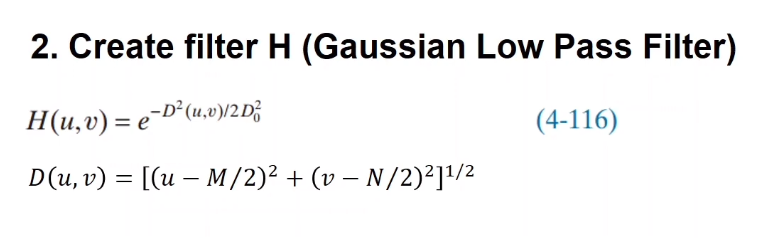

[Filtro Gaussiano](https://imgur.com/4jwCqbH)

Filtro mediana manual

In [ ]:
import cv2
import numpy as np
from skimage.util import random_noise

image = cv2.imread('t1.jpg')

def filtro_mediana_manual(image, tamanho_mascara):
    altura, largura, _ = image.shape
    output = np.zeros_like(image)

    for y in range(altura):
        for x in range(largura):
            for c in range(3):
                valores = []
                for ky in range(tamanho_mascara):
                    for kx in range(tamanho_mascara):
                        py = y - tamanho_mascara // 2 + ky
                        px = x - tamanho_mascara // 2 + kx
                        if py >= 0 and px >= 0 and py < altura and px < largura:
                            valores.append(image[py, px, c])
                output[y, x, c] = np.median(valores)

    return output

img_ruido = random_noise(image, mode='s&p', amount=0.05)
img_ruido = (255 * img_ruido).astype(np.uint8)

smoothed_3x3_manual = filtro_mediana_manual(img_ruido, 3)
smoothed_5x5_manual = filtro_mediana_manual(img_ruido, 5)
smoothed_7x7_manual = filtro_mediana_manual(img_ruido, 7)

cv2.imshow('Imagem Original', img_ruido)
cv2.imshow('Mediana Manual 3x3', smoothed_3x3_manual)
cv2.imshow('Mediana Manual 5x5', smoothed_5x5_manual)
cv2.imshow('Mediana Manual 7x7', smoothed_7x7_manual)
cv2.waitKey(0)
cv2.destroyAllWindows()


Cria-se uma matriz para a mascara de suavização, essa matriz é preenchida com 1 e, em seguida, dividida pela soma de todos os valores da matriz. Isso é feito para garantir que a soma dos elementos da matriz seja 1, o que é importante para manter o brilho da imagem após a suavização.
Após isto, clona-se a imagem inicial, com suas dimensões, porem, preenchendo-a com zeros. Essa matriz é utilizada para armazenar a imagem no final.
Após isto, começa um loop em cada pixel da imagem, percorrendo todas as coordendas e as três camadas de cores.
Internamente a este loop entre as coordenadas, existe outra iteração, que é responsavel por calcular as coordenadas dos pixel na vizinhança do pixel atual da iteração, verificando se esses pixels vizinhos estão dentro dos limites validos da imagem, se as coordenadas py e px forem válidas, o valor do pixel naquelas coordenadas é multiplicado pelo valor correspondente na máscara (mascara[ky, kx]) e adicionado à variável soma.

---


[Filtro mediana manual](https://imgur.com/43s2y46)

Filtro média manual

In [ ]:
import cv2
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt

image = cv2.imread('t1.jpg')

def filtro_media_manual(image, tamanho_mascara):
    altura, largura, _ = image.shape
    mascara = np.ones((tamanho_mascara, tamanho_mascara)) / (tamanho_mascara * tamanho_mascara)
    output = np.zeros_like(image)

    for y in range(altura):
        for x in range(largura):
            for c in range(3):
                soma = 0
                for ky in range(tamanho_mascara):
                    for kx in range(tamanho_mascara):
                        py = y - tamanho_mascara // 2 + ky
                        px = x - tamanho_mascara // 2 + kx
                        if py >= 0 and px >= 0 and py < altura and px < largura:
                            soma += image[py, px, c] * mascara[ky, kx]
                output[y, x, c] = int(soma)

    return output

img_ruido = random_noise(image, mode='s&p', amount=0.05)
img_ruido = (255 * img_ruido).astype(np.uint8)

img_3x3_suavizada = filtro_media_manual(img_ruido, 3)

img_5x5_suavizada = filtro_media_manual(img_ruido, 5)

img_7x7_suavizada = filtro_media_manual(img_ruido, 7)

cv2.imshow('Imagem Ruidosa', img_ruido)
cv2.imshow('Suavização Média 3x3', img_3x3_suavizada)
cv2.imshow('Suavização Média 5x5', img_5x5_suavizada)
cv2.imshow('Suavização Média 7x7', img_7x7_suavizada)
cv2.waitKey(0)
cv2.destroyAllWindows()

A diferença entre esse método  o anterior é que quandorealizamos a comparação entre os pixels estão dentro do limite válido da imagem, ocorr a multiplicação plo valor corrspondnte na mascara e adiciona a variavel soma. Após a iteração, o valor da soma é atribuido ao pixel correspondente na imagem de caída na msma posição e canal de cor. Como a soma é um valor de ponto flutuante, ele é convertido para inteiro antes de ser atribuido.

[Filtro média manual](https://imgur.com/xMrXiro)

## Sharpening

LAPLACIANO - 3.37 A

In [ ]:
import cv2
import numpy as np

img = cv2.imread('t1.jpg', cv2.IMREAD_GRAYSCALE)

mascara1 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)

img_mascarada1 = cv2.filter2D(img, -1, mascara1)

cv2.imshow("Imagem original", img)
cv2.imshow("Imagem mascarada 3.37 A", img_mascarada1)
cv2.waitKey(0)
cv2.destroyAllWindows()

[LAPLACIANO - 3.37 - A](https://imgur.com/n9RCv2G)

LAPLACIANO - 3.37 - B

In [ ]:
import cv2
import numpy as np

img = cv2.imread('t1.jpg', cv2.IMREAD_GRAYSCALE)

mascara2 = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)

img_mascarada2 = cv2.filter2D(img, -1, mascara2)

cv2.imshow("Imagem mascarada 3.37 B", img_mascarada2)
cv2.waitKey(0)
cv2.destroyAllWindows()


[LAPLACIANO - 3.37 - B](https://imgur.com/CGR74fE)

LAPLACIANO - 3.37 - C

In [ ]:
import cv2
import numpy as np

img = cv2.imread('t1.jpg', cv2.IMREAD_GRAYSCALE)

mascara3 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32)

img_mascarada3 = cv2.filter2D(img, -1, mascara3)

cv2.imshow("Imagem mascarada 3.37 C", img_mascarada3)
cv2.waitKey(0)
cv2.destroyAllWindows()


[LAPLACIANO - 3.37 - C](https://imgur.com/1Q8CAGz)

LAPLACIANO - 3.37 - D

In [ ]:
import cv2
import numpy as np

img = cv2.imread('t1.jpg', cv2.IMREAD_GRAYSCALE)

mascara3 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32)

img_mascarada3 = cv2.filter2D(img, -1, mascara3)

cv2.imshow('Imagem Original', img)
cv2.imshow("Imagem mascarada 3.37 C", img_mascarada3)
cv2.waitKey(0)
cv2.destroyAllWindows()

[LAPLACIANO - 3.37 - D](https://imgur.com/sSyEhjg)

SHARPENING - 3.38 A

In [ ]:
print("Imagem originaL")
cv2_imshow(img)

SHARPENING - 3.38 B

In [ ]:
import cv2
import numpy as np

img = cv2.imread('t1.jpg', cv2.IMREAD_GRAYSCALE)

mascara1 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)

img_mascarada1 = cv2.filter2D(img, -1, mascara1)
cv2.imshow("Imagem em Tons de Cinza", img)
cv2.imshow("Imagem mascarada 3.37 B", img_mascarada1)

cv2.waitKey(0)
cv2.destroyAllWindows()


[SHARPENING - 3.38 B](https://imgur.com/radfdQC)

SHARPENING - 3.38 C

[SHARPENING - 3.38 C](https://)

SHARPENING - 3.38 D - Imagem aguçada

In [ ]:
import cv2
import numpy as np

image = cv2.imread('t1.jpg', cv2.IMREAD_GRAYSCALE)

laplacian_mask = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
laplacian = cv2.filter2D(image, -1, laplacian_mask)

c = -1
sharpened_image = image + c * laplacian
sharpened_image = np.clip(sharpened_image, 0, 255)
sharpened_image = np.uint8(sharpened_image)

print("Sharpened Image")
cv2.imshow("Sharpened Image", sharpened_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


[SHARPENING - 3.38 D](https://imgur.com/Qm5pDue)

SHARPENING - 3.38 E

In [ ]:
import cv2
import numpy as np

image = cv2.imread('t1.jpg', cv2.IMREAD_GRAYSCALE)

laplacian_mask = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
laplacian = cv2.filter2D(image, -1, laplacian_mask)

c = -1
sharpened_image = image + c * laplacian
sharpened_image = np.clip(sharpened_image, 0, 255)
sharpened_image = np.uint8(sharpened_image)

print("Sharpened Image (Mask 3.37 B)")
cv2.imshow("Sharpened Image (Mask 3.37 B)", sharpened_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


[SHARPENING - 3.38 E](https://imgur.com/cZ6CEZY)

UNSHARP MASKING E HIGHBOOST FILTERING

In [ ]:
import cv2
import numpy as np

original_image = cv2.imread('t1.jpg')
blurred_image = cv2.GaussianBlur(original_image, (0, 0), 3)
sharpness_mask = cv2.subtract(original_image, blurred_image)

sharpened_image = cv2.add(original_image, sharpness_mask)
sharpened_image = np.clip(sharpened_image, 0, 255)
sharpened_image = np.uint8(sharpened_image)

print("Original Image")
cv2.imshow("Original Image", original_image)
print("\nSharpened Image")
cv2.imshow("Sharpened Image", sharpened_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


[UNSHARP MASKING E HIGHBOOST FILTERING](https://imgur.com/lSHslcC)

DETECTORES DE BORDA

LAPLACIANO

In [ ]:
import cv2
import numpy as np

img = cv2.imread('t1.jpg', cv2.IMREAD_GRAYSCALE)
laplace = cv2.Laplacian(img, cv2.CV_64F)
laplace = cv2.convertScaleAbs(laplace)

cv2.imshow("Imagem original",img)
cv2.imshow('Detector de borda',laplace)
cv2.waitKey(0)
cv2.destroyAllWindows()

[LAPLACIANO](https://imgur.com/AmLssVR)

ROBERTS

In [ ]:
import cv2
import numpy as np

image = cv2.imread('t1.jpg', cv2.IMREAD_GRAYSCALE)

kernel_x = np.array([[1, 0], [0, -1]], dtype=np.float32)
kernel_y = np.array([[0, 1], [-1, 0]], dtype=np.float32)

edge_x = cv2.filter2D(image, -1, kernel_x)
edge_y = cv2.filter2D(image, -1, kernel_y)

edge_roberts = cv2.addWeighted(edge_x, 0.5, edge_y, 0.5, 0)

cv2.imshow('Original', image)
cv2.imshow("Roberts", edge_roberts)

cv2.waitKey(0)
cv2.destroyAllWindows()


[ROBERTS](https://imgur.com/u9IAUin)

SOBEL

In [ ]:
import cv2
import numpy as np

image = cv2.imread('t1.jpg', cv2.IMREAD_GRAYSCALE)

edge_sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
edge_sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

edge_magnitude = cv2.magnitude(edge_sobel_x, edge_sobel_y)
edge_magnitude = cv2.convertScaleAbs(edge_magnitude)

cv2.imshow('Original', image)
cv2.imshow("Sobel", edge_magnitude)
cv2.waitKey(0)
cv2.destroyAllWindows()


[SOBEL](https://imgur.com/ifGmxpZ)

CANNY

In [ ]:
import cv2
import numpy as np

image = cv2.imread('t1.jpg', cv2.IMREAD_GRAYSCALE)

canny = cv2.Canny(image, 100, 200)

cv2.imshow("Original", image)
cv2.imshow("Canny", canny)
cv2.waitKey(0)
cv2.destroyAllWindows()

[CANNY](https://imgur.com/OWd6kcE)

Relate as observações visíveis nas imagens de saída com os filtros usados,
descrevendo o comportamento visual em relação as bordas, ruídos e esmaecimento da imagem com os diferentes kernels e para os diferentes algoritmos

---
- Durante a aplicação dos filtros, foi observado que o filtro "mediana manual" mostrou-se altamente eficaz na eliminação completa dos ruídos presentes na imagem. No entanto, essa eficácia veio acompanhada de um considerável efeito de desfoque na imagem, que não pode ser ignorado.

- Em contraste, o filtro de "suavização média" conseguiu reduzir alguns ruídos, embora não tenha alcançado o mesmo nível de desempenho que o "mediana manual". No entanto, assim como o primeiro filtro, também introduziu um notável desfoque na imagem.

- Por outro lado, o filtro "gaussiana manual" teve um desempenho relativamente modesto na remoção de ruídos, deixando grande parte deles intactos. Entretanto, este filtro teve um efeito de desfoque muito menor em comparação com os outros dois.

- Em resumo, pode-se concluir que, de forma geral, quanto maior o tamanho do kernel aplicado aos filtros, melhor é a remoção dos ruídos na imagem. No entanto, deve-se estar ciente de que um efeito colateral significativo desse processo é o desfoque da imagem, o que pode impactar negativamente na qualidade final da mesma. Portanto, a escolha do filtro e do tamanho do kernel deve ser feita considerando o equilíbrio entre a remoção de ruídos e a preservação da nitidez da imagem.


 Você observa uma discrepante melhoria na detecção de bordas pelo Canny em comparação aos outros 3 que justifique a complexidade adicional?

---
- De fato, o método de filtragem Canny demonstrou uma notável capacidade de
detecção de bordas, superando de maneira significativa os métodos de Sobel, Roberts e Laplaciano. A principal diferença entre este método e os demais é que ele é um filtro de convolução que usa a primeira derivada, no caso, suaviza o ruído e localiza bordas, combinando um operador diferencial com um filtro Gaussiano.

Aplique o filtro Sobel pós operação com um filtro de suavização (a sua escolha) e compare com a saída do Canny. Descreva suas observações técnicas sobre o comportamento.


In [ ]:
Não consegui fazer